In [1]:
import networkx as nx
from pyvis.network import Network
import pandas as pd 
from pythonds3.graphs import Graph, Vertex
from pythonds3.basic import Queue
import string
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm

## Discussion Questions

In [2]:
""" 
1. Draw the graph corresponding to the following adjacency matrix.
"""

def G_from_adjacency_matrix(matrix, node_names):
    #if there is directionality, then we assume the rows are source nodes,
    #and cols are target nodes 
    assert len(matrix) == len(node_names)
    G = nx.MultiDiGraph()

    for row in range(len(matrix)):
        for col in range(len(matrix[row])):
            if matrix[row][col] is not None:
                G.add_edge(node_names[row], node_names[col], weight=matrix[row][col])
    return G

def visualise_nx_graph(graph, directed=True, multi_edge=True, graph_name=None,
show_edge_weights=True):
    assert graph_name is not None and '.html' in graph_name
    net = Network(notebook=True, directed=directed)
    if multi_edge:
        net.set_edge_smooth('dynamic')
    net.from_nx(graph, show_edge_weights=show_edge_weights)
    net.show(graph_name)

adjacencyMatrix = [
    [None, 7, 5, None, None, 1],
    [2, None, None, 7, 3, None],
    [None, 2, None, None, None, 8],
    [1, None, None, None, 2, 4],
    [6, None, None, 5, None, None],
    [None, 1, None, None, 8, None]
]

#need to set net to directed and set_edge_smooth to dynamic to enable multiple edges between nodes

net_d1 = Network(notebook=True, directed=True)
G = G_from_adjacency_matrix(adjacencyMatrix, string.ascii_uppercase[:6])

visualise_nx_graph(G, graph_name='disc_q1.html')

In [3]:
"""
2. Draw the graph corresponding to the following list of edges.
"""

G = nx.MultiDiGraph()
edges = [(1, 2, 10),
        (1, 3, 15),
        (1, 6, 5),
        (2, 3, 7),
        (3, 4, 7),
        (3, 6, 10),
        (4, 5, 7),
        (6, 4, 5),
        (5, 6, 13)]

for edge in edges:
    G.add_edge(edge[0], edge[1], weight=edge[2])

visualise_nx_graph(G, graph_name='disc_q2.html', show_edge_weights=False,
directed=True)


In [4]:
"""
3. Ignoring the weights, perform a breadth first search on the graph from the previous question

    - implementing bfs from scratch using networkx graph object as an alternative way of answering the question
"""

def bfs_nx(g, start_node=None):
    assert start_node in list(g)
    #set_node_attributes: if nodes not specified, then applies to all nodes
    nx.set_node_attributes(g, 0, 'explore_status')
    nx.set_node_attributes(g, 0, 'distance')
    nx.set_node_attributes(g, None, 'predecessor')
    explore_queue = Queue()
    explore_queue.enqueue(start_node)
    while not explore_queue.is_empty():
        current_node = explore_queue.dequeue()
        #only keep neighbours that are not dead ends 
        neighbours = [neigh for neigh in list(g[current_node]) if g.nodes[neigh]['explore_status'] != 2]
        for neigh in neighbours:
            #we set exploration status to 1 - indicating that we've visited this node before, and predecessor 
            if g.nodes[neigh]['explore_status'] == 0:
                nx.set_node_attributes(g, {neigh: {'explore_status': 1, 'predecessor': current_node,
                                                    'distance': g.nodes[current_node]['distance'] + 1}})
                explore_queue.enqueue(neigh)
        
        nx.set_node_attributes(g, {current_node: {'explore_status': 2}})
    

def bfs_predecessors_nx(g, start_node):
    bfs_nx(g, start_node=start_node)
    predecessors = []
    for node in list(g):
        if node != start_node:
            predecessors.append((node, g.nodes[node]['predecessor']))
    
    return predecessors

In [5]:
#test bfs implementation
n_trials = 100
for _ in tqdm(range(n_trials)):
    n_nodes = random.randint(10, 50)
    p = random.uniform(0.5, 0.9)
    random_graph = nx.gnp_random_graph(n_nodes, p=p)
    assert sorted(list(nx.bfs_predecessors(random_graph, 1))) == sorted(bfs_predecessors_nx(random_graph, 1))

100%|██████████| 100/100 [00:00<00:00, 285.64it/s]


4. What is the Big-O running time of the buildGraph function? 

```python
def buildGraph(wordFile):
    d = {}
    g = Graph()
    wfile = open(wordFile,'r')
    # create buckets of words that differ by one letter
    for line in wfile:
        word = line[:-1]
        for i in range(len(word)):
            bucket = word[:i] + '_' + word[i+1:]
            if bucket in d:
                d[bucket].append(word)
            else:
                d[bucket] = [word]
    """
    in this step, O(k*n) where k = 4 in this instance b/c length of words is 4. 
    """

    # add vertices and edges for words in the same bucket
    for bucket in d.keys():
        for word1 in d[bucket]:
            for word2 in d[bucket]:
                if word1 != word2:
                    g.addEdge(word1,word2)

    """
    The maximum number of words in a bucket is 26, and theoretical upper bound of the number of buckets is 
    26^(k-1). So the theoretical maximum number of edges added is 26^k (from 26 * 26^(k-1))
    But, of course majority of the letter combinations will not be words... and this considers ALL possible k letter word combinations 
    which is overkill.

    If we consider the input size (5110 words in this case), 
    if we take n/26 = ~197, we get the minimum possible number of buckets.
    This assumes the case where the word list perfectly segments into buckets of 26 words (WORSE case, but pretty much impossible b/c again, 
    most combinations won't be words). 
    in this case, we will need to create 197 * (26 * 25) = 133,172 edges (theoretical maximum of edges needed in this scenario - in the actual
    buildGraph output there were only ~53,000 edges)

    so, combining the two processes:
    O(k*n) + O(n/26 * 26 * 25) -> O(k*n + (n * 25)) -> O(n(k + 1))

    ^ this is just my thinking of the process... because I suppose this is a particular case where we can identify an upper bound to the number of 
    edges quite easily, and so was trying to think of it in a different way, where we can quantify the coefficients.
    But the answer to the question is really just O(n^2) b/c the second 
    process involves two nested for loops that, which essentially always comes to n * (n-1) = n^2 - n operations, it's just that the 
    coefficient would differ based on the average number of words in each bucket (e.g. for the sample problem the coefficient would be
    0.002. AND in theory as n increases the coefficient no longer matters, but you know number of words is a pretty finite problem so)
    """    

    return g

```


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


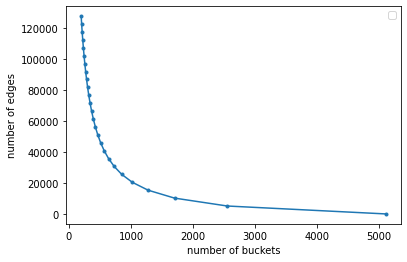

In [6]:
"""
Question 4. additional proof just to make sure my assumptions are correct in my own derivation... 
if the number of buckets increase, ie. the average number of words within each number decreases, the 
theoretical total number of edges added will also decrease.
"""

x = 5110
X = []
Y = []
for n_words in range(26, 0, -1):
    n_buckets = x/n_words 
    X.append(n_buckets)
    Y.append(n_buckets * (n_words * (n_words-1)))



plt.plot(X, Y, marker='.')

plt.xlabel('number of buckets')
plt.ylabel('number of edges')
plt.legend()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


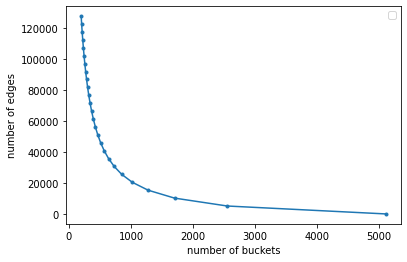

In [7]:
"""
Question 4. just wanted to compare the big-O that I derived and a straightforward n^2
"""

X = []
Y = []
for n_words in range(26, 0, -1):
    n_buckets = x/n_words 
    X.append(n_buckets)
    Y.append(n_buckets * (n_words * (n_words-1)))


plt.plot(X, Y, marker='.')

plt.xlabel('number of buckets')
plt.ylabel('number of edges')
plt.legend()

5.Derive the Big-O running time for the topological sort algorithm.


***
1. Call dfs(g) for some graph g. The main reason we want to call depth first search is to compute the finish times for each of the vertices.
***
    Time complexity of dfs is O(V + E)
***


2. Store the vertices in a list in decreasing order of finish time.
***
    We can store vertices during dfs; the main insight is that dfs always arrives at the final 
    node in the dfs tree first, and completes it, then goes back to complete the previous nodes. 
    Again, b/c dfs is a recursive function, it essentially is serving as a stack that pushes out 
    nodes as they "finish". So, during DFS, we simply need to append the finished nodes into self.finish_order
    to obtain an ordered list of nodes with increasing finishing times.
    We then return the reversed list (or we can list.insert(0, node) during dfs if we wish) as the result for topological sort.
    So this step does not increase the time complexity of that of dfs!
***

3. Return the ordered list as the result of the topological sort.
***
    Here we just need to reverse the list, which is an O(V) operation
***

Combining the big-O if the two operations:
O(V+E) + O(V) -> O(V+E)


In [26]:
#implentation of Q5 topological sort

class TopologicalSort_NX:
    __explore_status__ = 'explore_status'
    __predecessor__ = 'predecessor'
    __discovery_time__ = 'discovery_time'
    __finish_time__ = 'finish_time'
    
    def __init__(self, g):
        self._g = g
        self.finish_order = []
        self.time = 0

    def set_node_attribute(self, vertex=None, key=None, val=None):
        if vertex is None:
            #if no vertex is specified then we just set it for all nodes
            nx.set_node_attributes(self._g, val, key)
        else:
            assert vertex in list(self._g)
            nx.set_node_attributes(self._g, {vertex: {key: val}})

    def get_node_attribute(self, vertex, key):
        assert vertex in list(self._g)
        return self._g.nodes[vertex][key]

    def _topological_dfs(self):
        if self._g is None:
            raise Exception('no networkx graph object stored')
        #reset parameters
        self.time = 0
        self.finish_order = []
        self.set_node_attribute(key=TopologicalSort_NX.__explore_status__, val=0)
        self.set_node_attribute(key=TopologicalSort_NX.__predecessor__, val=None)
        self.set_node_attribute(key=TopologicalSort_NX.__discovery_time__, val=-1)
        self.set_node_attribute(key=TopologicalSort_NX.__finish_time__, val=-1)

        for vertex in list(self._g):
            if self._g.nodes[vertex][TopologicalSort_NX.__explore_status__] == 0:
                self._topological_dfsVisit(vertex)


    def _topological_dfsVisit(self, start_vertex):
        self.time += 1
        self.set_node_attribute(vertex=start_vertex, key=TopologicalSort_NX.__explore_status__, val=1)
        self.set_node_attribute(vertex=start_vertex, key=TopologicalSort_NX.__discovery_time__, val=self.time)

        for neighbour in list(self._g[start_vertex]):
            if self.get_node_attribute(neighbour, TopologicalSort_NX.__explore_status__) == 0:
                self.set_node_attribute(vertex=neighbour, key=TopologicalSort_NX.__explore_status__, val=1)
                self.set_node_attribute(vertex=neighbour, key=TopologicalSort_NX.__predecessor__, val=start_vertex)
                self._topological_dfsVisit(neighbour)
        
        self.time += 1
        #finish node exploration
        self.set_node_attribute(vertex=start_vertex, key=TopologicalSort_NX.__finish_time__, val=self.time)
        self.set_node_attribute(vertex=start_vertex, key=TopologicalSort_NX.__explore_status__, val=2)
        #here we append the finished vertex to self.order for topologicalSort
        #check that the finishing time for this 
        if len(self.finish_order):
            last = self.get_node_attribute(vertex=self.finish_order[-1], key=TopologicalSort_NX.__finish_time__)
            curr = self.get_node_attribute(vertex=start_vertex, key=TopologicalSort_NX.__finish_time__)
            assert last < curr
        self.finish_order.append(start_vertex)

    
    def topologicalSort(self):
        self._topological_dfs()
        return self.finish_order[::-1]
        



In [27]:
#test Topological sort implementation 
def generate_dag(n=5, p=0.5, directed=True):
    #generates a random dag
    g = nx.gnp_random_graph(n, p, directed=directed)
    #only keep edges that point from lower to higher indices - stackoverflow
    DAG = nx.MultiDiGraph([(u, v, {'weight': random.randint(-10, 10)}) for (u,v) in g.edges() if u < v])
    assert nx.is_directed_acyclic_graph(DAG)
    return DAG


def topological_sort_check(graph, res, mode='vertex'):
    """
    Topological sort definition:
    an ordering of the nodes such that for every edge (u,v) in G,
    u appears earlier than v in the ordering

    - both modes looking at the same thing, just examining it from a different perspective
    """

    if mode == 'vertex':
        """
        vertex mode:
        we iterate through the vertices from the sort.
        At each vertex we look at the outgoing edges. If the target of any outgoing edges precedes the 
        vertex in the ordering, then the sort result is invalid!

        time complexity: O(V^2 * E)
        """
        for i,node in enumerate(res):
            preceding = res[:i]
            out_edges = graph.out_edges(node)
            for _, target in out_edges:
                if target in preceding:
                    return False 
    elif mode == 'edge':
        """
        edge mode:
        we look at all the edges in G. for each edge, we get the index of its vertex
        within the ordering. If the origin vertex isn't earlier than the target vertex,
        then the ordering is invalid!
        - here it's important that the graph is a DAG, because or else there will exist edges 
        that point from a later ordering back to an earlier vertex
        - BASICALLY the definitin of topological ordering (look above)

        time complexity: O(E*V)
        """
        edges = list(graph.edges())
        for source, target in edges:
            source_idx = res.index(source)
            target_idx = res.index(target)
            if source_idx > target_idx:
                return False
    return True

                    

n_trials = 100
for _ in tqdm(range(n_trials)):
    n = random.randint(10, 200)
    p = 0.5
    dag = generate_dag(n, p, directed=True)
    ts = TopologicalSort_NX(dag)
    res = ts.topologicalSort()
    assert topological_sort_check(ts._g, res, mode='edge')



100%|██████████| 100/100 [00:12<00:00,  8.21it/s]


6.Derive the Big-O running time for the strongly connected components algorithm.

1. Call dfs for the graph  to compute the finish times for each vertex.

***
    Time complexity of dfs is O(V+E)
***

2. Compute G<sup>T</sup>

3. Call dfs for the graph  but in the main loop of DFS explore each vertex in decreasing order of finish time.

4. Each tree in the forest computed in step 3 is a strongly connected component. Output the vertex ids for each vertex in each tree in the forest to identify the component.